In [1]:
from textwrap import dedent

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit


def model(x: float, a: float, b: float) -> float:
    """
    A fitting model
    
    Parameters
    ----------
    x: float
        Kinetic energy (eV)
    a: float
        Time delay (as)
    b: float
        Offset of phase shift (rad)
    
    Returns
    -------
    float
        Phase shift (rad)
    """
    return a * x / 24.1888432651 * 0.0367493 + b

In [2]:
sheets = pd.read_excel('Data/Ne phase shift summary, 2018-12-22.xlsx', sheet_name=None)

for sheet in sheets.values():
    sheet.sort_values('Photon (eV)', inplace=True)
    sheet['KE (eV)'] = 2 * sheet['Photon (eV)'] - 24.58738880
groupped = {
    k: v.groupby('Photon (eV)').mean()
    for k, v in sheets.items()
}

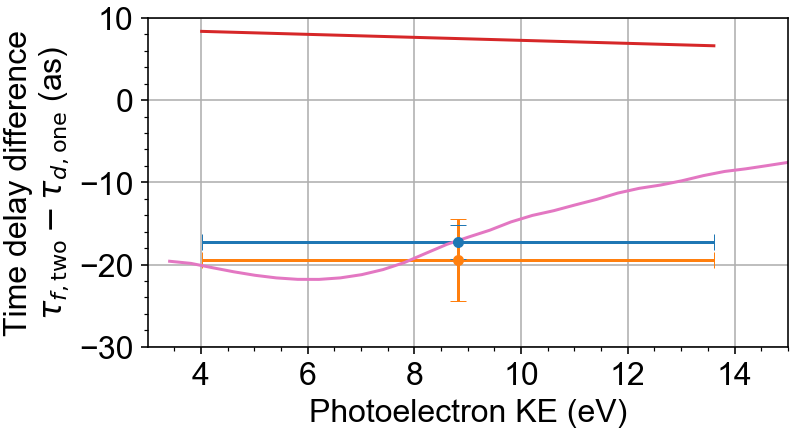

In [24]:
plt.style.use('My Presentation.mplstyle')
plt.figure(figsize=(11.9,6.8))
plt.xlabel('Photoelectron KE (eV)')
plt.ylabel('Time delay difference\n'r'${\tau_f}_{\rm,two} - {\tau_d}_{\rm,one}$ (as)')

prop = plt.rcParams['axes.prop_cycle']
offset = 0
for k, p in zip(sheets, prop):
    if k not in {"TDCASSCF, projected",
                 "Elena, simul",
                 "Exp, β1 shift (neglected p)",
                 "Exp, GF (including p)"}:
        continue
    plt.plot([], '-', label=k, **p)
    
    if k in {"Elena, simul",
             "TDCASSCF, projected"}:
        df = groupped[k]
        df["Time delay (as)"] = np.gradient(df["Phase shift (rad)"], df["KE (eV)"]) * 24.1888432651 / 0.0367493
        plt.plot(df["KE (eV)"], df["Time delay (as)"],
                 '-', label='', **p)
    
    if k in {"Elena, GF (including p)"}:
        df = groupped[k]
        x0, x1 = df["KE (eV)"].min(), df["KE (eV)"].max()
        opt, cov = curve_fit(model, df["KE (eV)"], df["Phase shift (rad)"])
        plt.errorbar([(x0 + x1) / 2], [opt[0]],
                     xerr=[(x1 - x0) / 2],
                     yerr=[cov[0, 0] ** 0.5],
                     label='', **p)

    if k in {"Exp, β1 shift (neglected p)",
             "Exp, GF (including p)",
             "Exp, GF (inc p, scaled amps)"}:
        where = ~groupped[k]["Phase shift (rad)"].isna()
        df = groupped[k][where]
        opt, cov = curve_fit(
            model,
            df["KE (eV)"],
            df["Phase shift (rad)"],
            sigma=df["Phase shift error (rad)"],
            absolute_sigma=True,
        )
        x0, x1 = df["KE (eV)"].min(), df["KE (eV)"].max()
        plt.errorbar([(x0 + x1) / 2 + offset], [opt[0]],
                     xerr=[(x1 - x0) / 2],
                     yerr=[cov[0, 0] ** 0.5],
                     fmt='o',
                     label='', **p)
        offset += 0
plt.grid(True)
# plt.legend(loc='lower right', bbox_to_anchor=(1, 1), ncol=2)
plt.xlim(3, 15)
plt.ylim(-30, 10)
plt.tight_layout()
pos = plt.gca().get_position()
plt.savefig("Figures/Compare Ne time delays, slide.pdf")
plt.show()

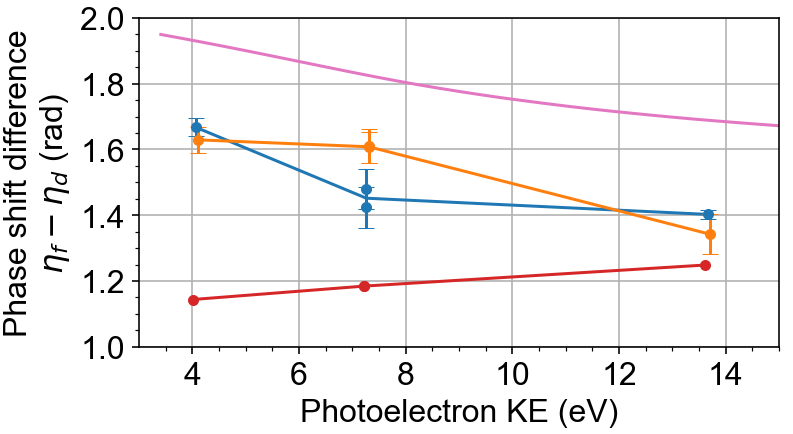

In [23]:
plt.style.use('My Presentation.mplstyle')
plt.figure(figsize=(11.9,6.8))
plt.xlabel('Photoelectron KE (eV)')
plt.ylabel('Phase shift difference\n'r'$\eta_f-\eta_d$ (rad)')

prop = plt.rcParams['axes.prop_cycle']
offset = 0.05
for k, p in zip(sheets, prop):
    if k not in {"TDCASSCF, projected",
                 "Elena, simul",
                 "Exp, β1 shift (neglected p)",
                 "Exp, GF (including p)"}:
        continue
    plt.plot([], '-', label=k, **p)
    if 'Phase shift error (rad)' in sheets[k]:
        plt.plot(groupped[k]['KE (eV)'] + offset, groupped[k]['Phase shift (rad)'], '-', label='', **p)
        plt.errorbar(sheets[k]['KE (eV)'] + offset,
                     sheets[k]['Phase shift (rad)'],
                     yerr=sheets[k]['Phase shift error (rad)'],
                     fmt='o', label='', **p)
        offset += 0.05
    else:
        plt.plot(groupped[k]['KE (eV)'], groupped[k]['Phase shift (rad)'], '-', label='', **p)
        if not k.endswith("simul"):
            plt.plot(sheets[k]['KE (eV)'], sheets[k]['Phase shift (rad)'], 'o', label='', **p)
plt.grid(True)
# plt.legend(loc='lower right', bbox_to_anchor=(1, 1), ncol=2)
plt.xlim(3, 15)
plt.ylim(1, 2)
plt.tight_layout()
plt.gca().set_position(pos)
plt.savefig("Figures/Compare Ne phase shifts, slide.pdf")
plt.show()